In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/gdrive/MyDrive/coco')
sys.path.append('/content/gdrive/MyDrive')

import glob
import pickle
import zipfile
import tqdm.notebook as tq

import torch
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

# Fast Loader Class
* Normal dataset loading slowed down training too much

In [3]:
class FastTensorDataLoader:
    """
    A DataLoader-like object for a set of tensors that can be much faster than
    TensorDataset + DataLoader because dataloader grabs individual indices of
    the dataset and calls cat (slow).
    Source: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, *tensors, batch_size=32, shuffle=False):
        """
        Initialize a FastTensorDataLoader.
        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.
        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

# Train and Test dataset + dataloader

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [5]:
# Loading in train and test tensors. Ram after loading: 7.44gb
train_x = torch.load('/content/gdrive/MyDrive/Final_Tensors/train_x.pt').to('cpu')
train_y = torch.load('/content/gdrive/MyDrive/Final_Tensors/train_y.pt').to('cpu')

eval_x = torch.load('/content/gdrive/MyDrive/Final_Tensors/eval_x.pt').to('cpu')
eval_y = torch.load('/content/gdrive/MyDrive/Final_Tensors/eval_y.pt').to('cpu')

In [6]:
test_x = torch.load('/content/gdrive/MyDrive/Final_Tensors/test_x.pt').to('cpu')
test_y = torch.load('/content/gdrive/MyDrive/Final_Tensors/test_y.pt').to('cpu')

In [7]:
# Model Parameters
EPOCHS = 50
BATCH_SIZE = 256
LEARNING_RATE = 0.001
INPUT_SIZE = train_x.shape[1]

criterion = nn.BCEWithLogitsLoss() # no need for last sigmoid node in model

# Dataset setup
train_batches = FastTensorDataLoader(train_x, train_y, batch_size=BATCH_SIZE, shuffle=True) # serves as dataset and dataloader for tabular data
eval_batches = FastTensorDataLoader(eval_x, eval_y, batch_size=BATCH_SIZE, shuffle=True) 
test_batches = FastTensorDataLoader(test_x, test_y, batch_size=BATCH_SIZE, shuffle=True)

In [19]:
def get_accuracy(y_pred, y_true):
    y_pred = torch.round(torch.sigmoid(y_pred))

    y_pred = y_pred.to('cpu').numpy()
    y_true = y_true.to('cpu').numpy()
    acc = accuracy_score(y_pred, y_true) * 100

    return acc

def get_outputs(y_pred):
    y_pred = torch.round(torch.sigmoid(y_pred))
    y_pred = y_pred.to('cpu').numpy()

    ones = len(np.where(y_pred == 1)[0])
    zeros = len(np.where(y_pred == 0)[0])

    return ones, zeros


def validation(model, eval_loader):
  model.eval()

  y_pred = []
  y_actual = [] 
  
  with torch.no_grad():
    # Run through each batch of eval dataset
    for x_batch, y_batch in eval_loader:
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      y_actual_batch = y_batch.unsqueeze(1)
      y_pred_batch = model(x_batch.float().to(device))

      y_actual.extend(y_actual_batch)
      y_pred.extend(y_pred_batch)

  return torch.stack(y_pred), torch.stack(y_actual)

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

# Final Model Training


In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix, classification_report

In [9]:
class NLQ_Security(nn.Module): # MODEL 3, same as base just two more hidden layers
    def __init__(self):
        super(NLQ_Security, self).__init__()

        # Input Layer
        self.input_layer = nn.Linear(INPUT_SIZE, 64) 

        # Hidden Layers
        self.layer_2 = nn.Linear(64, 64)
        self.layer_3 = nn.Linear(64, 64)
        self.layer_4 = nn.Linear(64, 64)
        
        # Out Layer
        self.output_layer = nn.Linear(64, 1) 
        
        # Reg features
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.batchnorm4 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        # Relu on input layer outputs, then normalization
        x = self.relu(self.input_layer(inputs))
        x = self.batchnorm1(x)
        
        # HL 1
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        
        x = self.relu(self.layer_4(x))
        x = self.batchnorm4(x)
        
        # Out layer
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

In [20]:
# RUN NEW MODEL AND TRAIN.
del model
torch.cuda.empty_cache() 
model = NLQ_Security()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
  epoch_loss = 0
  epoch_acc = 0
  model.train()
  # Go through each batch in training data
  for x_batch, y_batch in train_batches:

    # Since training on GPU now
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    
    # Clear out gradients for new batch
    optimizer.zero_grad()

    y_pred = model(x_batch.float())
        
    loss = criterion(y_pred, y_batch.unsqueeze(1))
    acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
    loss.backward()
    optimizer.step()
        
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  # Check Model's performance on eval set after going through one full epoch of training data
  eval_pred, eval_true = validation(model, eval_batches)
  eval_acc = get_accuracy(eval_pred, eval_true)
  
  ones, zeros = get_outputs(eval_pred)
  print(f'Ones: {ones}\nZeros: {zeros}')
  print(f'Epoch {epoch+0:03}: | Loss: {epoch_loss/len(train_batches):.5f} | Acc: {epoch_acc/len(train_batches):.3f} | Eval Acc: {eval_acc:.3f}')

Ones: 8662
Zeros: 32697
Epoch 000: | Loss: 0.44530 | Acc: 75.390 | Eval Acc: 78.658
Ones: 10223
Zeros: 31136
Epoch 001: | Loss: 0.34168 | Acc: 82.934 | Eval Acc: 84.555
Ones: 9929
Zeros: 31430
Epoch 002: | Loss: 0.28771 | Acc: 86.271 | Eval Acc: 85.643
Ones: 10245
Zeros: 31114
Epoch 003: | Loss: 0.26469 | Acc: 87.623 | Eval Acc: 86.416
Ones: 10605
Zeros: 30754
Epoch 004: | Loss: 0.24768 | Acc: 88.533 | Eval Acc: 86.499
Ones: 10288
Zeros: 31071
Epoch 005: | Loss: 0.23497 | Acc: 89.246 | Eval Acc: 86.719
Ones: 10837
Zeros: 30522
Epoch 006: | Loss: 0.22378 | Acc: 89.777 | Eval Acc: 86.615
Ones: 9933
Zeros: 31426
Epoch 007: | Loss: 0.21486 | Acc: 90.255 | Eval Acc: 86.760
Ones: 11434
Zeros: 29925
Epoch 008: | Loss: 0.20741 | Acc: 90.666 | Eval Acc: 86.748
Ones: 11243
Zeros: 30116
Epoch 009: | Loss: 0.20023 | Acc: 91.031 | Eval Acc: 86.562
Ones: 10646
Zeros: 30713
Epoch 010: | Loss: 0.19418 | Acc: 91.380 | Eval Acc: 86.932
Ones: 10791
Zeros: 30568
Epoch 011: | Loss: 0.18901 | Acc: 91.589 | 

# Evaluation

In [24]:
def get_predictions(y_pred, y_true):
    y_pred = torch.round(torch.sigmoid(y_pred))

    y_pred = y_pred.to('cpu').numpy()
    y_true = y_true.to('cpu').numpy()

    return y_pred, y_true

In [25]:
test_pred, test_true = validation(model, test_batches)
test_acc = get_accuracy(test_pred, test_true)
test_y_hat, test_y_actual = get_predictions(test_pred, test_true)
test_acc

85.10929964994737

In [29]:
cf_matrix= confusion_matrix(test_y_actual, test_y_hat)

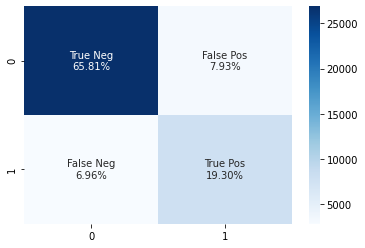

In [31]:
group_names = ['True Neg','False Pos','False Neg','True Pos']


group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
                     
labels = [f'{v1}\n{v3}' for v1, v3 in
          zip(group_names, group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [34]:
print(classification_report(test_y_actual, test_y_hat))

              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90     30121
         1.0       0.71      0.73      0.72     10730

    accuracy                           0.85     40851
   macro avg       0.81      0.81      0.81     40851
weighted avg       0.85      0.85      0.85     40851



# Experimental Models with Training Stats logged

In [ ]:
class Clip_nlp(nn.Module): # MODEL 3, same as base just two more hidden layers
    def __init__(self):
        super(Clip_nlp, self).__init__()

        # Input Layer
        self.layer_1 = nn.Linear(INPUT_SIZE, 64) 

        # Hidden Layers
        self.layer_2 = nn.Linear(64, 64)
        self.layer_3 = nn.Linear(64, 64)
        self.layer_4 = nn.Linear(64, 64)
        
        # Out Layer
        self.layer_out = nn.Linear(64, 1) 
        
        # Reg features
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.batchnorm4 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        # Relu on input layer outputs, then normalization
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        
        # HL 1
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        
        x = self.relu(self.layer_4(x))
        x = self.batchnorm4(x)
        
        # Out layer
        x = self.dropout(x)
        x = self.layer_out(x)
        return x

Epoch 000: | Loss: 0.46768 | Acc: 74.186 | Eval Acc: 79.000
Epoch 001: | Loss: 0.34383 | Acc: 82.783 | Eval Acc: 84.000
Epoch 002: | Loss: 0.29810 | Acc: 85.520 | Eval Acc: 85.000
Epoch 003: | Loss: 0.27298 | Acc: 87.072 | Eval Acc: 85.000
Epoch 004: | Loss: 0.25464 | Acc: 88.087 | Eval Acc: 86.000
Epoch 005: | Loss: 0.24009 | Acc: 88.859 | Eval Acc: 86.000
Epoch 006: | Loss: 0.22869 | Acc: 89.460 | Eval Acc: 86.000
Epoch 007: | Loss: 0.21797 | Acc: 90.040 | Eval Acc: 86.000
Epoch 008: | Loss: 0.20903 | Acc: 90.484 | Eval Acc: 86.000
Epoch 009: | Loss: 0.20111 | Acc: 90.951 | Eval Acc: 86.000
Epoch 010: | Loss: 0.19349 | Acc: 91.316 | Eval Acc: 86.000
Epoch 011: | Loss: 0.18750 | Acc: 91.581 | Eval Acc: 86.000
Epoch 012: | Loss: 0.18111 | Acc: 91.939 | Eval Acc: 86.000
Epoch 013: | Loss: 0.17548 | Acc: 92.206 | Eval Acc: 86.000
Epoch 014: | Loss: 0.17009 | Acc: 92.475 | Eval Acc: 86.000
Epoch 015: | Loss: 0.16564 | Acc: 92.740 | Eval Acc: 86.000
Epoch 016: | Loss: 0.16137 | Acc: 92.904 | Eval Acc: 86.000
Epoch 017: | Loss: 0.15739 | Acc: 93.128 | Eval Acc: 86.000
Epoch 018: | Loss: 0.15315 | Acc: 93.300 | Eval Acc: 86.000
Epoch 019: | Loss: 0.14974 | Acc: 93.453 | Eval Acc: 86.000
Epoch 020: | Loss: 0.14623 | Acc: 93.628 | Eval Acc: 86.000
Epoch 021: | Loss: 0.14271 | Acc: 93.794 | Eval Acc: 86.000
Epoch 022: | Loss: 0.13975 | Acc: 93.987 | Eval Acc: 85.000
Epoch 023: | Loss: 0.13694 | Acc: 94.045 | Eval Acc: 85.000
Epoch 024: | Loss: 0.13382 | Acc: 94.191 | Eval Acc: 86.000
Epoch 025: | Loss: 0.13061 | Acc: 94.336 | Eval Acc: 85.000
Epoch 026: | Loss: 0.12873 | Acc: 94.424 | Eval Acc: 85.000
Epoch 027: | Loss: 0.12690 | Acc: 94.534 | Eval Acc: 85.000
Epoch 028: | Loss: 0.12491 | Acc: 94.623 | Eval Acc: 85.000
Epoch 029: | Loss: 0.12201 | Acc: 94.771 | Eval Acc: 85.000
Epoch 030: | Loss: 0.12000 | Acc: 94.821 | Eval Acc: 85.000
Epoch 031: | Loss: 0.11785 | Acc: 94.935 | Eval Acc: 85.000
Epoch 032: | Loss: 0.11654 | Acc: 95.025 | Eval Acc: 85.000
Epoch 033: | Loss: 0.11376 | Acc: 95.179 | Eval Acc: 85.000
Epoch 034: | Loss: 0.11154 | Acc: 95.280 | Eval Acc: 85.000
Epoch 035: | Loss: 0.11076 | Acc: 95.303 | Eval Acc: 85.000
Epoch 036: | Loss: 0.10847 | Acc: 95.410 | Eval Acc: 85.000
Epoch 037: | Loss: 0.10660 | Acc: 95.455 | Eval Acc: 85.000
Epoch 038: | Loss: 0.10718 | Acc: 95.493 | Eval Acc: 85.000
Epoch 039: | Loss: 0.10453 | Acc: 95.554 | Eval Acc: 85.000
Epoch 040: | Loss: 0.10231 | Acc: 95.641 | Eval Acc: 85.000
Epoch 041: | Loss: 0.10184 | Acc: 95.686 | Eval Acc: 85.000
Epoch 042: | Loss: 0.09975 | Acc: 95.774 | Eval Acc: 85.000
Epoch 043: | Loss: 0.09869 | Acc: 95.852 | Eval Acc: 85.000
Epoch 044: | Loss: 0.09733 | Acc: 95.859 | Eval Acc: 85.000
Epoch 045: | Loss: 0.09572 | Acc: 95.922 | Eval Acc: 85.000
Epoch 046: | Loss: 0.09523 | Acc: 95.944 | Eval Acc: 85.000
Epoch 047: | Loss: 0.09390 | Acc: 96.020 | Eval Acc: 84.000
Epoch 048: | Loss: 0.09205 | Acc: 96.103 | Eval Acc: 85.000
Epoch 049: | Loss: 0.09159 | Acc: 96.114 | Eval Acc: 85.000

In [ ]:
# MODEL 3: 128 at 3 hidden layers
class Clip_nlp(nn.Module):
    def __init__(self):
        super(Clip_nlp, self).__init__()

        # Input Layer
        self.layer_1 = nn.Linear(INPUT_SIZE, 128) 

        # Hidden Layers
        self.layer_2 = nn.Linear(128, 128)
        self.layer_3 = nn.Linear(128, 128)
        self.layer_4 = nn.Linear(128, 128)
        
        # Out Layer
        self.layer_out = nn.Linear(128, 1) 
        
        # Reg features
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.batchnorm4 = nn.BatchNorm1d(128)
        
    def forward(self, inputs):
        # Relu on input layer outputs, then normalization
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        
        # HL 1
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        
        x = self.relu(self.layer_4(x))
        x = self.batchnorm4(x)
        
        # Out layer
        x = self.dropout(x)
        x = self.layer_out(x)
        return x

Epoch 000: | Loss: 0.46243 | Acc: 74.522 | Eval Acc: 79.000
Epoch 001: | Loss: 0.33179 | Acc: 83.482 | Eval Acc: 84.000
Epoch 002: | Loss: 0.28039 | Acc: 86.540 | Eval Acc: 85.000
Epoch 003: | Loss: 0.25104 | Acc: 88.283 | Eval Acc: 86.000
Epoch 004: | Loss: 0.22831 | Acc: 89.453 | Eval Acc: 86.000
Epoch 005: | Loss: 0.21008 | Acc: 90.462 | Eval Acc: 86.000
Epoch 006: | Loss: 0.19428 | Acc: 91.280 | Eval Acc: 86.000
Epoch 007: | Loss: 0.18085 | Acc: 91.939 | Eval Acc: 86.000
Epoch 008: | Loss: 0.16815 | Acc: 92.587 | Eval Acc: 86.000
Epoch 009: | Loss: 0.15665 | Acc: 93.112 | Eval Acc: 86.000
Epoch 010: | Loss: 0.14697 | Acc: 93.585 | Eval Acc: 86.000
Epoch 011: | Loss: 0.13709 | Acc: 94.052 | Eval Acc: 86.000
Epoch 012: | Loss: 0.12824 | Acc: 94.527 | Eval Acc: 86.000
Epoch 013: | Loss: 0.12176 | Acc: 94.854 | Eval Acc: 86.000
Epoch 014: | Loss: 0.11399 | Acc: 95.184 | Eval Acc: 86.000
Epoch 015: | Loss: 0.10805 | Acc: 95.433 | Eval Acc: 86.000
Epoch 016: | Loss: 0.10220 | Acc: 95.749 | Eval Acc: 86.000
Epoch 017: | Loss: 0.09671 | Acc: 95.908 | Eval Acc: 85.000
Epoch 018: | Loss: 0.09137 | Acc: 96.179 | Eval Acc: 86.000
Epoch 019: | Loss: 0.08704 | Acc: 96.361 | Eval Acc: 86.000
Epoch 020: | Loss: 0.08304 | Acc: 96.545 | Eval Acc: 86.000
Epoch 021: | Loss: 0.07889 | Acc: 96.726 | Eval Acc: 86.000
Epoch 022: | Loss: 0.07587 | Acc: 96.850 | Eval Acc: 86.000
Epoch 023: | Loss: 0.07294 | Acc: 96.960 | Eval Acc: 85.000
Epoch 024: | Loss: 0.07009 | Acc: 97.126 | Eval Acc: 86.000
Epoch 025: | Loss: 0.06714 | Acc: 97.280 | Eval Acc: 85.000
Epoch 026: | Loss: 0.06463 | Acc: 97.381 | Eval Acc: 86.000
Epoch 027: | Loss: 0.06148 | Acc: 97.507 | Eval Acc: 86.000
Epoch 028: | Loss: 0.06007 | Acc: 97.585 | Eval Acc: 85.000
Epoch 029: | Loss: 0.05807 | Acc: 97.648 | Eval Acc: 85.000
Epoch 030: | Loss: 0.05525 | Acc: 97.767 | Eval Acc: 86.000
Epoch 031: | Loss: 0.05463 | Acc: 97.836 | Eval Acc: 85.000
Epoch 032: | Loss: 0.05228 | Acc: 97.922 | Eval Acc: 85.000
Epoch 033: | Loss: 0.04993 | Acc: 98.025 | Eval Acc: 86.000
Epoch 034: | Loss: 0.05048 | Acc: 98.007 | Eval Acc: 85.000
Epoch 035: | Loss: 0.04758 | Acc: 98.126 | Eval Acc: 85.000
Epoch 036: | Loss: 0.04580 | Acc: 98.229 | Eval Acc: 85.000
Epoch 037: | Loss: 0.04513 | Acc: 98.217 | Eval Acc: 85.000
Epoch 038: | Loss: 0.04368 | Acc: 98.298 | Eval Acc: 85.000
Epoch 039: | Loss: 0.04244 | Acc: 98.352 | Eval Acc: 85.000
Epoch 040: | Loss: 0.04151 | Acc: 98.406 | Eval Acc: 85.000
Epoch 041: | Loss: 0.04181 | Acc: 98.399 | Eval Acc: 85.000
Epoch 042: | Loss: 0.03917 | Acc: 98.491 | Eval Acc: 86.000
Epoch 043: | Loss: 0.03946 | Acc: 98.464 | Eval Acc: 85.000
Epoch 044: | Loss: 0.03796 | Acc: 98.552 | Eval Acc: 85.000
Epoch 045: | Loss: 0.03555 | Acc: 98.661 | Eval Acc: 85.000
Epoch 046: | Loss: 0.03697 | Acc: 98.608 | Eval Acc: 85.000
Epoch 047: | Loss: 0.03471 | Acc: 98.688 | Eval Acc: 85.000
Epoch 048: | Loss: 0.03548 | Acc: 98.673 | Eval Acc: 85.000
Epoch 049: | Loss: 0.03338 | Acc: 98.769 | Eval Acc: 85.000

In [ ]:
# Model 4, 3 hidden layers with leakyrelu 
class Clip_nlp(nn.Module): # MODEL 3
    def __init__(self):
        super(Clip_nlp, self).__init__()

        # Input Layer
        self.layer_1 = nn.Linear(INPUT_SIZE, 64) 

        # Hidden Layers
        self.layer_2 = nn.Linear(64, 64)
        self.layer_3 = nn.Linear(64, 64)
        self.layer_4 = nn.Linear(64, 64)
        
        # Out Layer
        self.layer_out = nn.Linear(64, 1) 
        
        # Reg features
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.batchnorm4 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        # Relu on input layer outputs, then normalization
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        
        # HL 1
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        
        x = self.relu(self.layer_4(x))
        x = self.batchnorm4(x)
        
        # Out layer
        x = self.dropout(x)
        x = self.layer_out(x)
        return x
        
Epoch 000: | Loss: 0.47582 | Acc: 73.446 | Eval Acc: 78.000
Epoch 001: | Loss: 0.36522 | Acc: 81.155 | Eval Acc: 83.000
Epoch 002: | Loss: 0.30022 | Acc: 85.397 | Eval Acc: 84.000
Epoch 003: | Loss: 0.27188 | Acc: 87.126 | Eval Acc: 86.000
Epoch 004: | Loss: 0.25211 | Acc: 88.240 | Eval Acc: 86.000
Epoch 005: | Loss: 0.23767 | Acc: 88.987 | Eval Acc: 85.000
Epoch 006: | Loss: 0.22469 | Acc: 89.709 | Eval Acc: 86.000
Epoch 007: | Loss: 0.21363 | Acc: 90.285 | Eval Acc: 86.000
Epoch 008: | Loss: 0.20492 | Acc: 90.767 | Eval Acc: 86.000
Epoch 009: | Loss: 0.19612 | Acc: 91.204 | Eval Acc: 86.000
Epoch 010: | Loss: 0.18808 | Acc: 91.610 | Eval Acc: 86.000
Epoch 011: | Loss: 0.18179 | Acc: 91.879 | Eval Acc: 86.000
Epoch 012: | Loss: 0.17500 | Acc: 92.314 | Eval Acc: 86.000
Epoch 013: | Loss: 0.16994 | Acc: 92.507 | Eval Acc: 86.000
Epoch 014: | Loss: 0.16363 | Acc: 92.812 | Eval Acc: 86.000
Epoch 015: | Loss: 0.15873 | Acc: 93.056 | Eval Acc: 85.000
Epoch 016: | Loss: 0.15450 | Acc: 93.251 | Eval Acc: 86.000
Epoch 017: | Loss: 0.14998 | Acc: 93.446 | Eval Acc: 86.000
Epoch 018: | Loss: 0.14567 | Acc: 93.704 | Eval Acc: 86.000
Epoch 019: | Loss: 0.14198 | Acc: 93.870 | Eval Acc: 86.000
Epoch 020: | Loss: 0.13837 | Acc: 94.036 | Eval Acc: 85.000
Epoch 021: | Loss: 0.13466 | Acc: 94.229 | Eval Acc: 86.000
Epoch 022: | Loss: 0.13112 | Acc: 94.348 | Eval Acc: 85.000
Epoch 023: | Loss: 0.12788 | Acc: 94.543 | Eval Acc: 85.000
Epoch 024: | Loss: 0.12453 | Acc: 94.717 | Eval Acc: 85.000
Epoch 025: | Loss: 0.12187 | Acc: 94.821 | Eval Acc: 85.000
Epoch 026: | Loss: 0.11956 | Acc: 94.922 | Eval Acc: 85.000
Epoch 027: | Loss: 0.11734 | Acc: 95.047 | Eval Acc: 85.000
Epoch 028: | Loss: 0.11406 | Acc: 95.197 | Eval Acc: 85.000
Epoch 029: | Loss: 0.11156 | Acc: 95.316 | Eval Acc: 85.000
Epoch 030: | Loss: 0.10962 | Acc: 95.401 | Eval Acc: 85.000
Epoch 031: | Loss: 0.10743 | Acc: 95.500 | Eval Acc: 85.000
Epoch 032: | Loss: 0.10545 | Acc: 95.581 | Eval Acc: 85.000
Epoch 033: | Loss: 0.10307 | Acc: 95.711 | Eval Acc: 85.000
Epoch 034: | Loss: 0.10205 | Acc: 95.711 | Eval Acc: 85.000
Epoch 035: | Loss: 0.09929 | Acc: 95.870 | Eval Acc: 85.000
Epoch 036: | Loss: 0.09718 | Acc: 95.928 | Eval Acc: 85.000
Epoch 037: | Loss: 0.09609 | Acc: 95.973 | Eval Acc: 85.000
Epoch 038: | Loss: 0.09295 | Acc: 96.087 | Eval Acc: 85.000
Epoch 039: | Loss: 0.09235 | Acc: 96.157 | Eval Acc: 85.000
Epoch 040: | Loss: 0.09075 | Acc: 96.215 | Eval Acc: 85.000
Epoch 041: | Loss: 0.08895 | Acc: 96.305 | Eval Acc: 85.000
Epoch 042: | Loss: 0.08793 | Acc: 96.370 | Eval Acc: 85.000
Epoch 043: | Loss: 0.08682 | Acc: 96.374 | Eval Acc: 85.000
Epoch 044: | Loss: 0.08563 | Acc: 96.487 | Eval Acc: 85.000
Epoch 045: | Loss: 0.08374 | Acc: 96.498 | Eval Acc: 85.000
Epoch 046: | Loss: 0.08298 | Acc: 96.619 | Eval Acc: 85.000
Epoch 047: | Loss: 0.08138 | Acc: 96.641 | Eval Acc: 85.000
Epoch 048: | Loss: 0.08055 | Acc: 96.688 | Eval Acc: 85.000
Epoch 049: | Loss: 0.07852 | Acc: 96.776 | Eval Acc: 85.000

In [ ]:
# Fat model 1
class Clip_nlp(nn.Module): # MODEL 3
    def __init__(self):
        super(Clip_nlp, self).__init__()

        # Input Layer
        self.layer_1 = nn.Linear(INPUT_SIZE, 512) 

        # Hidden Layers
        self.layer_2 = nn.Linear(512, 512)
        self.layer_3 = nn.Linear(512, 512)

        self.layer_4 = nn.Linear(512, 128)

        self.layer_5 = nn.Linear(128, 64)
        self.layer_6 = nn.Linear(64, 64)
        
        # Out Layer
        self.layer_out = nn.Linear(64, 1) 
        
        # Reg features
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(512)
        self.batchnorm3 = nn.BatchNorm1d(512)
        self.batchnorm4 = nn.BatchNorm1d(128)
        self.batchnorm5 = nn.BatchNorm1d(64)
        self.batchnorm6 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        # Relu on input layer outputs, then normalization
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        
        # HL 1
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        # HL 2
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        # HL 3
        x = self.relu(self.layer_4(x))
        x = self.batchnorm4(x)
        # HL 4
        x = self.relu(self.layer_5(x))
        x = self.batchnorm5(x)
        # HL 5
        x = self.relu(self.layer_6(x))
        x = self.batchnorm6(x)    

        # Out layer
        x = self.dropout(x)
        x = self.layer_out(x)
        return x

Epoch 000: | Loss: 0.46227 | Acc: 74.480 | Eval Acc: 78.000
Epoch 001: | Loss: 0.33834 | Acc: 83.036 | Eval Acc: 85.000
Epoch 002: | Loss: 0.27191 | Acc: 87.038 | Eval Acc: 86.000
Epoch 003: | Loss: 0.23435 | Acc: 89.186 | Eval Acc: 86.000
Epoch 004: | Loss: 0.20497 | Acc: 90.767 | Eval Acc: 87.000
Epoch 005: | Loss: 0.18020 | Acc: 91.964 | Eval Acc: 86.000
Epoch 006: | Loss: 0.15955 | Acc: 92.984 | Eval Acc: 87.000
Epoch 007: | Loss: 0.14030 | Acc: 93.960 | Eval Acc: 87.000
Epoch 008: | Loss: 0.12399 | Acc: 94.720 | Eval Acc: 86.000
Epoch 009: | Loss: 0.10927 | Acc: 95.390 | Eval Acc: 86.000
Epoch 010: | Loss: 0.09530 | Acc: 96.018 | Eval Acc: 86.000
Epoch 011: | Loss: 0.08552 | Acc: 96.426 | Eval Acc: 86.000
Epoch 012: | Loss: 0.07547 | Acc: 96.897 | Eval Acc: 86.000
Epoch 013: | Loss: 0.06741 | Acc: 97.244 | Eval Acc: 86.000
Epoch 014: | Loss: 0.06086 | Acc: 97.547 | Eval Acc: 86.000
Epoch 015: | Loss: 0.05580 | Acc: 97.776 | Eval Acc: 86.000
Epoch 016: | Loss: 0.05125 | Acc: 97.942 | Eval Acc: 86.000
Epoch 017: | Loss: 0.04683 | Acc: 98.139 | Eval Acc: 86.000
Epoch 018: | Loss: 0.04367 | Acc: 98.276 | Eval Acc: 86.000
Epoch 019: | Loss: 0.04096 | Acc: 98.413 | Eval Acc: 86.000
Epoch 020: | Loss: 0.03806 | Acc: 98.554 | Eval Acc: 86.000
Epoch 021: | Loss: 0.03584 | Acc: 98.628 | Eval Acc: 86.000
Epoch 022: | Loss: 0.03330 | Acc: 98.744 | Eval Acc: 86.000
Epoch 023: | Loss: 0.03220 | Acc: 98.787 | Eval Acc: 86.000
Epoch 024: | Loss: 0.03082 | Acc: 98.852 | Eval Acc: 86.000
Epoch 025: | Loss: 0.02930 | Acc: 98.910 | Eval Acc: 86.000
Epoch 026: | Loss: 0.02819 | Acc: 98.978 | Eval Acc: 86.000
Epoch 027: | Loss: 0.02683 | Acc: 98.975 | Eval Acc: 86.000
Epoch 028: | Loss: 0.02539 | Acc: 99.029 | Eval Acc: 86.000
Epoch 029: | Loss: 0.02479 | Acc: 99.043 | Eval Acc: 86.000
Epoch 030: | Loss: 0.02384 | Acc: 99.085 | Eval Acc: 86.000
Epoch 031: | Loss: 0.02342 | Acc: 99.128 | Eval Acc: 86.000
Epoch 032: | Loss: 0.02211 | Acc: 99.168 | Eval Acc: 86.000
Epoch 033: | Loss: 0.02127 | Acc: 99.164 | Eval Acc: 86.000
Epoch 034: | Loss: 0.02096 | Acc: 99.184 | Eval Acc: 86.000
Epoch 035: | Loss: 0.02030 | Acc: 99.229 | Eval Acc: 86.000
Epoch 036: | Loss: 0.01950 | Acc: 99.249 | Eval Acc: 86.000
Epoch 037: | Loss: 0.01863 | Acc: 99.307 | Eval Acc: 86.000
Epoch 038: | Loss: 0.01888 | Acc: 99.278 | Eval Acc: 86.000
Epoch 039: | Loss: 0.01841 | Acc: 99.289 | Eval Acc: 86.000
Epoch 040: | Loss: 0.01713 | Acc: 99.408 | Eval Acc: 86.000
Epoch 041: | Loss: 0.01741 | Acc: 99.379 | Eval Acc: 86.000
Epoch 042: | Loss: 0.01725 | Acc: 99.379 | Eval Acc: 86.000
Epoch 043: | Loss: 0.01573 | Acc: 99.491 | Eval Acc: 86.000
Epoch 044: | Loss: 0.01678 | Acc: 99.383 | Eval Acc: 86.000
Epoch 045: | Loss: 0.01525 | Acc: 99.513 | Eval Acc: 86.000
Epoch 046: | Loss: 0.01520 | Acc: 99.502 | Eval Acc: 86.000
Epoch 047: | Loss: 0.01521 | Acc: 99.525 | Eval Acc: 86.000
Epoch 048: | Loss: 0.01470 | Acc: 99.540 | Eval Acc: 86.000
Epoch 049: | Loss: 0.01382 | Acc: 99.561 | Eval Acc: 86.000